In [ ]:
import os
import zipfile
import shutil
import time
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Dropout, Reshape, Multiply, Conv2D, Add, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, average_precision_score

import time

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1jGKC9pNjrWqJJTMJRFDnKD5W-GAl1xhV&export=download'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1jGKC9pNjrWqJJTMJRFDnKD5W-GAl1xhV&export=download
From (redirected): https://drive.google.com/uc?id=1jGKC9pNjrWqJJTMJRFDnKD5W-GAl1xhV&export=download&confirm=t&uuid=7fc80b20-5111-492b-b50e-7eea6ed6a340
To: /content/dataset.zip
100%|██████████| 173M/173M [00:03<00:00, 54.3MB/s]


'dataset.zip'

In [ ]:
# Ekstrak dataset
local_zip = '/content/dataset.zip'
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/file')

data_path = '/content/file'
# Periksa direktori yang diekstrak
print(os.listdir(data_path))

['dataset']


In [ ]:
train_dir = '/content/file/dataset/train'
val_dir = '/content/file/dataset/val'
test_dir = '/content/file/dataset/test'

In [ ]:
# Tentukan parameter
batch_size = 32
img_height = 260
img_width = 260
epochs = 20

In [ ]:
# Buat ImageDataGenerator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
# ImageDataGenerator untuk data validation
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
# ImageDataGenerator untuk data testing
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
# Buat generator untuk data training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 6908 images belonging to 2 classes.


In [ ]:
# Generator untuk data validasi
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 1973 images belonging to 2 classes.


In [ ]:
# Generator untuk data testing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 988 images belonging to 2 classes.


In [ ]:
# Definisikan fungsi CBAM (Convolutional Block Attention Module)
def cbam_block(input_feature, ratio=8):
    # Channel Attention Module
    channel = input_feature.shape[-1]

    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    channel_attention = Add()([avg_pool, max_pool])
    channel_attention = Activation('sigmoid')(channel_attention)

    # Apply Channel Attention
    channel_refined_feature = Multiply()([input_feature, channel_attention])

    # Spatial Attention Module
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined_feature)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = Conv2D(filters=1,
                               kernel_size=7,
                               strides=1,
                               padding='same',
                               activation='sigmoid',
                               kernel_initializer='he_normal',
                               use_bias=False)(concat)

    # Apply Spatial Attention
    refined_feature = Multiply()([channel_refined_feature, spatial_attention])

    return refined_feature

In [ ]:
# Load model EfficientNetV2 tanpa lapisan atas (include_top=False)
base_model = EfficientNetV2B2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

# Bekukan lapisan base_model
base_model.trainable = False

In [ ]:
# Tambahkan lapisan atas dengan CBAM
x = base_model.output
x = cbam_block(x)  # Tambahkan CBAM
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Buat model lengkap
model = Model(inputs=base_model.input, outputs=outputs)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 260, 260, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 260, 260, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 260, 260, 3)    │              0 │ rescaling_1[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 130, 130, 32)   │            864 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 130, 130, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 130, 130, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 130, 130, 16)   │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 130, 130, 16)   │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 130, 130, 16)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 130, 130, 16)   │          2,304 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 130, 130, 16)   │             64 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 130, 130, 16)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 130, 130, 16)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 130, 130, 16)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_project_activ… │
├──────────────────────

 Total params: 9,268,081 (35.35 MB)

 Trainable params: 498,707 (1.90 MB)

 Non-trainable params: 8,769,374 (33.45 MB)

In [ ]:
# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Tambahkan EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True
)

In [ ]:
# Hitung waktu komputasi
start_time_training = time.time()

# Latih model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stop]
)

end_time_training = time.time()
training_time = end_time_training - start_time_training
print(f"Waktu komputasi training: {training_time:.2f} detik")

Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 124s 562ms/step - accuracy: 0.9323 - loss: 0.1784 - val_accuracy: 0.9513 - val_loss: 0.1347
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - accuracy: 0.9688 - loss: 0.0810 - val_accuracy: 1.0000 - val_loss: 0.0217
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 122s 545ms/step - accuracy: 0.9325 - loss: 0.1688 - val_accuracy: 0.9518 - val_loss: 0.1330
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.9688 - loss: 0.1091 - val_accuracy: 1.0000 - val_loss: 0.0201
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 123s 552ms/step - accuracy: 0.9424 - loss: 0.1525 - val_accuracy: 0.9524 - val_loss: 0.1315
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9375 - loss: 0.1814 - val_accuracy: 1.0000 - val_loss: 0.0669
Waktu komputasi training: 374.47 detik


In [ ]:
# Hitung waktu testing
start_time_testing = time.time()

# Evaluasi model pada data testing
test_loss, test_acc = model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)
print('Akurasi pada data testing:', test_acc)

end_time_testing = time.time()
testing_time = end_time_testing - start_time_testing
print(f"Waktu komputasi testing: {testing_time:.2f} detik")

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9735 - loss: 0.0868
Akurasi pada data testing: 0.9583333134651184
Waktu komputasi testing: 3.18 detik


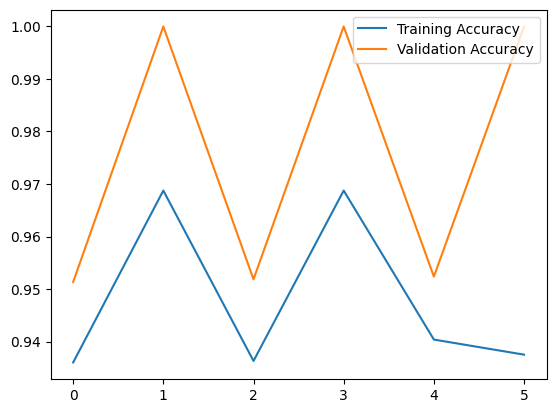

In [ ]:
# Plot akurasi
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

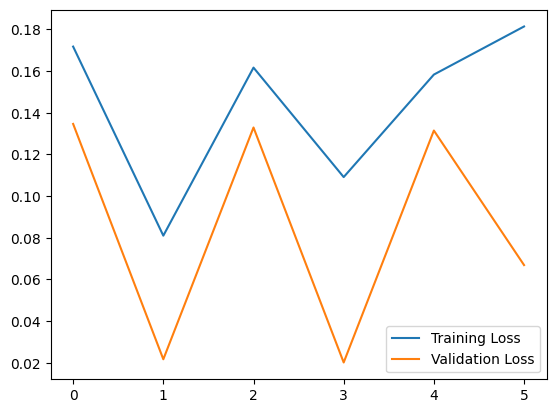

In [ ]:
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step


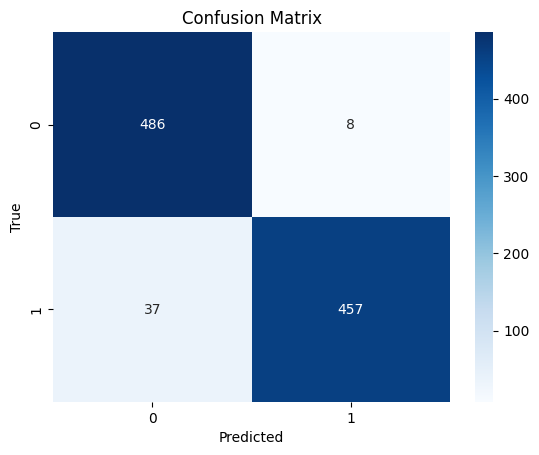

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Buat prediksi pada data testing
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)

# Dapatkan label sebenarnya dari generator
y_true = test_generator.classes

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Tampilkan confusion matrix menggunakan seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hitung metrik
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Tampilkan hasil
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.9545
Precision: 0.9828
Recall: 0.9251
F1-score: 0.9531


In [ ]:
from sklearn.metrics import average_precision_score

# Asumsikan y_true dan y_pred adalah array numpy yang berisi label sebenarnya dan prediksi probabilitas
# Untuk setiap kelas

y_pred_proba = model.predict(test_generator)  # Dapatkan prediksi probabilitas

average_precision = average_precision_score(y_true, y_pred_proba)

print(f"Average precision score: {average_precision:.4f}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step
Average precision score: 0.9906


In [ ]:
# Simpan model
model.save('efficientnetv2_drowsiness_model_dual_attention.h5')

In [ ]:
from sklearn.metrics import classification_report

# Hitung laporan klasifikasi
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())

# Tampilkan laporan klasifikasi
print(report)


              precision    recall  f1-score   support

      closed       0.93      0.98      0.96       494
        open       0.98      0.93      0.95       494

    accuracy                           0.95       988
   macro avg       0.96      0.95      0.95       988
weighted avg       0.96      0.95      0.95       988



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


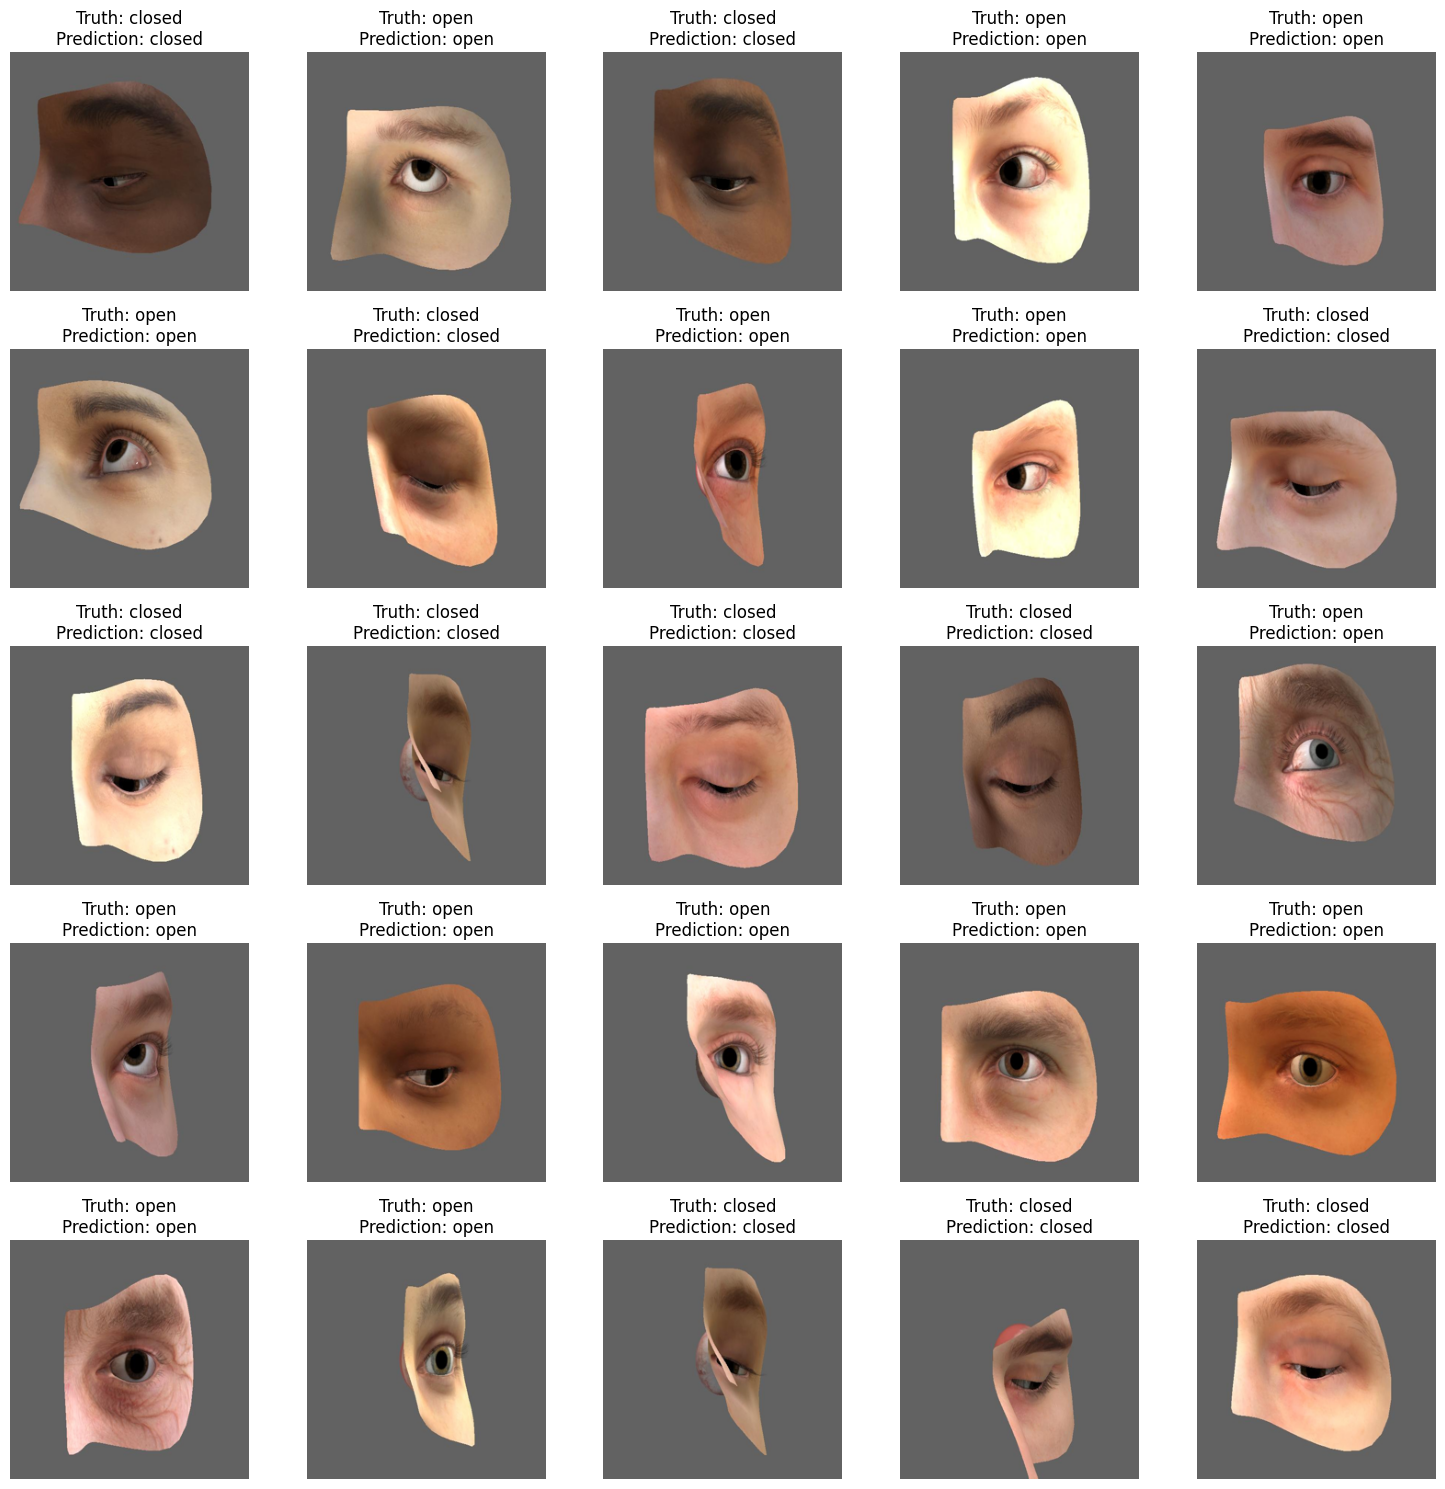

In [ ]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

# Definisikan direktori test
test_dir = '/content/file/dataset/test'

# Daftar kelas
class_names = sorted(os.listdir(test_dir))

# Jumlah gambar yang akan ditampilkan
num_images = 25

# Ukuran frame
rows = 5
cols = 5

# Buat figure dan axes
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Loop untuk menampilkan gambar
for i in range(num_images):
    # Pilih kelas secara acak
    class_name = random.choice(class_names)

    # Pilih gambar secara acak dari kelas tersebut
    image_path = os.path.join(test_dir, class_name, random.choice(os.listdir(os.path.join(test_dir, class_name))))

    # Buka gambar menggunakan PIL
    img = Image.open(image_path)

    # Prediksi kelas gambar
    img = img.resize((img_width, img_height))  # Ubah ukuran gambar
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Tambahkan dimensi batch
    img_array = preprocess_input(img_array)  # Praproses gambar

    prediction = model.predict(img_array)
    predicted_class = "open" if prediction > 0.5 else "closed"

    # Tampilkan gambar pada axes
    row = i // cols
    col = i % cols
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Truth: {class_name}\nPrediction: {predicted_class}")
    axes[row, col].axis('off')

# Tampilkan plot
plt.tight_layout()
plt.show()